## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [2]:
!pip install skorch
# library sklearn x Pytorch

     |████████████████████████████████| 155 kB 9.7 MB/s 


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
import matplotlib.pyplot as plt

%matplotlib inline

cuda


## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [4]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [5]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [26]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [7]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [8]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

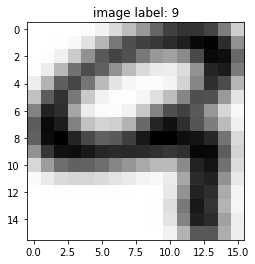

In [9]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

## Train your Model

In [43]:
# Create the model: 
model = Model()
model.to(device="cuda:0")
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)

In [44]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    # dataset.to(device)
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device)
            # print(images.device)
            labels = labels.to(device)
            # print(labels.device)
            # print(images.shape)
            # print(images.view(batch_size, -1).shape)
            y_pre = model(images.view(batch_size, -1)) 
            #y_pre = model(images)
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [45]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

RuntimeError: ignored

Text(0.5, 1.0, 'Visualization of convergence')

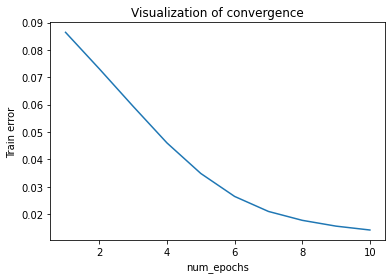

In [13]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [57]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader: 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return round(100*correct.item()/ len(dataset), 2)

In [58]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

RuntimeError: ignored

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [59]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.1):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=1)
        self.conv4_drop = nn.Dropout2d(p=dropout)

        self.fc1 = nn.Linear(65536, 100) # 256 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x): 
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4_drop(self.conv4(x)))
         
        # flatten over channel, height and width = 256 = 16*16 
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3)) 
        # print(x.shape)
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        # x = torch.softmax(self.fc2(x), dim=-1) 
        x = self.fc2(x)

        return x

In [60]:
# define a function for training
def train_cnn(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images = images.to(device="cuda:0")
            labels = labels.to(device="cuda:0")
            y_pre = model(images)
            
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [75]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_sizes = [10] #100, 500, 1000] #, 

# Use mean squared loss function 
criterions = [torch.nn.CrossEntropyLoss()] #nn.MSELoss(), 
             
drop_outs = [0.1, 0.25, 0.5] 
lr = [0.1, 0.05, 0.01, 0.001, 10] 
# It is initialized on our model
optimizers = ["Adam", "RMSProp", "SGD", ]

In [86]:
f = []
for drop_out in drop_outs:
  # Create the model: 
  cnn = Cnn(dropout=drop_out)
  cnn.to(device="cuda:0")

  for batch_size in batch_sizes:  
    for l in lr:  
      for opt in optimizers:
        if opt == "SGD":  optimizer = torch.optim.SGD(cnn.parameters(), lr=l)
        if opt == "Adam": optimizer = torch.optim.Adam(cnn.parameters(), lr=l)
        if opt == "RMSProp": optimizer = torch.optim.RMSprop(cnn.parameters(), lr=l)
      
        for criterion in criterions:
          print(l, opt, batch_size, criterion, drop_out)
          train_error_cnn = train_cnn(num_epochs, batch_size, criterion, optimizer, cnn, train_set)
          v = accuracy(val_set, cnn)
          a = accuracy(test_set, cnn)
          result = (l, opt, batch_size, criterion, drop_out, train_error_cnn, v, a)
          f.append(result)
          print(f)
f

0.1 Adam 10 CrossEntropyLoss() 0.1
Epoch [1/10], Loss: 49.6225
Epoch [2/10], Loss: 2.2906
Epoch [3/10], Loss: 2.2948
Epoch [4/10], Loss: 2.2947
Epoch [5/10], Loss: 2.2914
Epoch [6/10], Loss: 2.2916
Epoch [7/10], Loss: 2.2936
Epoch [8/10], Loss: 2.2935
Epoch [9/10], Loss: 2.2907
Epoch [10/10], Loss: 2.2928
Accuracy of the model : 9.45 %
Accuracy of the model : 8.47 %
[(0.1, 'Adam', 10, CrossEntropyLoss(), 0.1, [49.62246821443241, 2.290566621422769, 2.2947673976421337, 2.294687066078184, 2.291381714542709, 2.291649054686228, 2.2935842740535723, 2.29346019486586, 2.290659516851109, 2.2927881886561714], 9.45, 8.47)]
0.1 RMSProp 10 CrossEntropyLoss() 0.1
Epoch [1/10], Loss: 2.3003
Epoch [2/10], Loss: 2.2942
Epoch [3/10], Loss: 2.2960
Epoch [4/10], Loss: 2.2926
Epoch [5/10], Loss: 2.2939
Epoch [6/10], Loss: 2.2918
Epoch [7/10], Loss: 2.2931
Epoch [8/10], Loss: 2.2955
Epoch [9/10], Loss: 2.2922
Epoch [10/10], Loss: 2.2928
Accuracy of the model : 15.65 %
Accuracy of the model : 17.89 %
[(0.1, 

[(0.1,
  'Adam',
  10,
  CrossEntropyLoss(),
  0.1,
  [49.62246821443241,
   2.290566621422769,
   2.2947673976421337,
   2.294687066078184,
   2.291381714542709,
   2.291649054686228,
   2.2935842740535723,
   2.29346019486586,
   2.290659516851109,
   2.2927881886561714],
  9.45,
  8.47),
 (0.1,
  'RMSProp',
  10,
  CrossEntropyLoss(),
  0.1,
  [2.3003402159611364,
   2.2942253249883655,
   2.295960778196655,
   2.2925732350349435,
   2.2938973971207957,
   2.2918036741018293,
   2.2930932637055714,
   2.2954525526364624,
   2.2921571034193056,
   2.292782364885012],
  15.65,
  17.89),
 (0.1,
  'SGD',
  10,
  CrossEntropyLoss(),
  0.1,
  [2.2736473512649567,
   2.2718124075730644,
   2.2710057181119927,
   2.2711821728944765,
   2.271344413161277,
   2.2721732834974926,
   2.271907187302908,
   2.2714746449391012,
   2.271154163479805,
   2.271895084381101],
  15.65,
  17.89),
 (0.05,
  'Adam',
  10,
  CrossEntropyLoss(),
  0.1,
  [2.2794886859258017,
   2.281032005349792,
   2.28018

In [81]:
import pandas as pd
gf = pd.DataFrame(final)
gf.head()

,0,1,2,3,4,5,6,7
0,0.10,Adam,100,CrossEntropyLoss(),0.1,"[334.35764764547355, 2.2720926841100058, 2.271...",15.65,17.89
1,0.10,RMSProp,100,CrossEntropyLoss(),0.1,"[2.2940438469250997, 2.281462275981902, 2.2776...",15.65,17.89
2,0.10,SGD,100,CrossEntropyLoss(),0.1,"[2.271901230017345, 2.2700659394264227, 2.2693...",15.65,17.89
3,0.05,Adam,100,CrossEntropyLoss(),0.1,"[2.2721183141072587, 2.273477776845296, 2.2732...",15.65,17.89
4,0.05,RMSProp,100,CrossEntropyLoss(),0.1,"[2.280059746901195, 2.273645619551341, 2.27295...",15.65,17.89


In [90]:
z = pd.DataFrame(f)
z.head()


,0,1,2,3,4,5,6,7
0,0.10,Adam,10,CrossEntropyLoss(),0.1,"[49.62246821443241, 2.290566621422769, 2.29476...",9.45,8.47
1,0.10,RMSProp,10,CrossEntropyLoss(),0.1,"[2.3003402159611364, 2.2942253249883655, 2.295...",15.65,17.89
2,0.10,SGD,10,CrossEntropyLoss(),0.1,"[2.2736473512649567, 2.2718124075730644, 2.271...",15.65,17.89
3,0.05,Adam,10,CrossEntropyLoss(),0.1,"[2.2794886859258017, 2.281032005349792, 2.2801...",13.71,13.15
4,0.05,RMSProp,10,CrossEntropyLoss(),0.1,"[2.284969203472137, 2.2818969617287332, 2.2808...",15.65,17.89


In [91]:

g = pd.concat([gf, z])
g.to_csv("/content/g.csv")

In [ ]:
 # cnn = NeuralNetClassifier(
#     Cnn,
#     max_epochs=10,
#     lr=0.002,
#     optimizer=torch.optim.Adam,
#     device=device
# )

In [ ]:
params = {
    'lr': [0.05, 0.1],
    'module__num_units': [10, 20],
    'module__dropout': [0, 0.5],
    'optimizer__nesterov': [False, True],
}

In [115]:
# gs = GridSearchCV(cnn, params, refit=False, cv=3, scoring='accuracy', verbose=2)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [63]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [64]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [18]:
accuracy(test_set, model)

Accuracy of the model : 89.39 %
